In [1]:
import sys
import os

from copy import deepcopy
import h5py

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

myhost = os.uname()[1]
sys.path.insert(0, '/home/elott1/code/')
data_dir = "/home/elott1/data/packaged/"
work_dir = '/home/elott1/code/NTdatasets/hartley/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")

print(f'Running on Computer: [{myhost}]')
print(f'Data directory: {data_dir}')
print(f'Working directory: {work_dir}')

%load_ext autoreload
%autoreload 2

Running on Computer: [PFC]
Data directory: /home/elott1/data/packaged/
Working directory: /home/elott1/code/NTdatasets/hartley/


In [2]:
# NDN tools
import NDNT.utils as utils          # some other utilities\n",
from NDNT.utils import imagesc      # because I'm lazy\n",
from NDNT.utils import ss           # because I'm real lazy\n",
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

Invoking __init__.py for NDNT.utils


In [3]:
fn0 = 'Jocamo_220628_full_HC_ETCC_nofix_v08'
f = h5py.File(os.path.join(data_dir, fn0+'.mat'), 'r')

In [4]:
from NTdatasets.hartley.hartley import HartleyDataset

expts = [fn0]

data = HartleyDataset(
    filenames=expts,
    datadir=data_dir,
    num_lags=10,
    time_embed=2,
    include_MUs=False,
    preload=True,
    drift_interval=None,
    device=device0,
    eye_config=3,
    maxT=12000
)

Loading data into memory...
Stim: using laminar probe stimulus
  Adding fixation point
  Time embedding...
  Done
Meta: using laminar probe stimulus
  Time embedding...
	Done
T-range: 0 12000
Extending final block at  11760 12000


(4, 10, 140)


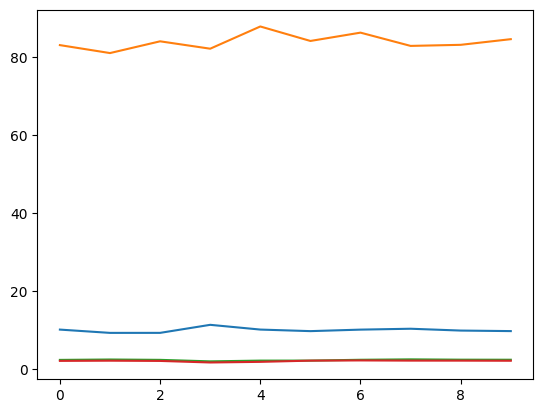

In [28]:
# Calculate STA 
Reff = data.robs * data.dfs
nspks = torch.sum(Reff, axis=0)
stas = (data.meta.T@data.robs / nspks).reshape([-1, data.num_lags, data.NC]).detach().numpy()
print(stas.shape)
plt.plot(stas[0,:,2])
plt.plot(stas[1,:,2])
plt.plot(stas[2,:,2])
plt.plot(stas[3,:,2])
# plot first 6
#num_col = np.minimum(stas.shape[-1], 6)
#ss(1, 5)
#for cc in range(5):
#    plt.subplot(1, 5, cc+1)
#    imagesc(stas[:,:,cc])

In [5]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    history_size=10,
    batch_size=4000,
    max_epochs=3,
    max_iter = 2000,
    device = device)

#data.add_covariate('metadata', data.meta[:12000])

In [6]:
print(data.stim_dims)
print(data.stim.shape)
print(data.meta_dims)
print(data.meta[:12000].shape)

[3, 60, 60, 10]
torch.Size([12000, 108000])
[1, 1, 4, 10]
torch.Size([12000, 40])


In [7]:
XTreg0 = 1.0
L1reg0 = 0.0001

glm_all_par = NDNLayer.layer_dict( 
    input_dims=data.meta_dims,
    num_filters=data.NC, 
    bias=True,
    initialize_center = True,
    NLtype='softplus'
    )

glm_all_par['reg_vals'] = {
    'd2xt': XTreg0,
    'l1':L1reg0,
    'localx':0.001,
    'bcs':{'d2xt':1}
    } 

glm_net = FFnetwork.ffnet_dict(xstim_n='meta', layer_list=[glm_all_par])

In [13]:
print(data.val_inds.shape)
print(data.used_inds.shape)
print(glm_net.values())

(2400,)
(11650,)
dict_values([[{'layer_type': 'normal', 'input_dims': [1, 1, 4, 10], 'num_filters': 140, 'NLtype': 'softplus', 'norm_type': 0, 'pos_constraint': False, 'num_inh': 0, 'bias': True, 'weights_initializer': 'xavier_uniform', 'bias_initializer': 'zeros', 'output_norm': None, 'initialize_center': True, 'reg_vals': {'d2xt': 1.0, 'l1': 0.0001, 'localx': 0.001, 'bcs': {'d2xt': 1}}}], 'meta', None, 'normal'])


In [20]:
torch.cuda.empty_cache()
## Fit all GLMs at once -- example for choice of regularization above
glm_all = NDN.NDN(ffnet_list=[glm_net])
glm_all.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
LLs = glm_all.eval_models(data[data.val_inds], null_adjusted=True)
print(LLs)
print(np.mean(LLs))

[ 0.01015139  0.01142931  0.03863478  0.0346477  -0.25410986 -0.00848627
  0.03270471  0.02429581 -0.03452349 -0.03715444 -0.0283215   0.00510168
 -0.01497316 -0.19494963 -0.15124655 -0.06134462 -0.003268   -0.0108707
  0.00719881  0.02649164 -0.02723837  0.00443578  0.10135078 -0.03833628
 -0.07416248  0.02003741  0.02622795  0.02395558  0.05290532 -0.02519631
 -0.02925181 -0.00996351 -0.02087951 -0.00942779  0.00077194 -0.03829455
 -0.04023767 -0.03617549 -0.06477666 -0.04842043 -0.01255393 -0.07558417
 -0.01243687 -0.07052183 -0.02064729 -0.05830812 -0.02141452 -0.04575968
  0.00339937 -0.00388861 -0.07340646 -0.01475215 -0.00393915 -0.01542449
  0.00096285 -0.23998499 -0.04026747 -0.02666473 -0.15573812 -0.0173583
 -0.02618337 -0.01498652 -0.00637877 -0.03425503 -0.00708938 -0.0304966
 -0.06866193 -0.00420439 -0.02806687 -0.01614761 -0.01815748 -0.02642775
 -0.03966331 -0.0171473  -0.05503941 -0.02623415 -0.01020432 -0.05086327
 -0.01145363 -0.01483655 -0.05389714 -0.01137543 -0.09

In [14]:
## Optimize d2xt regularization
reglist = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
LLsR = np.zeros([len(reglist), data.NC])
data.set_cells()
for rr in range(len(reglist)):
    glm_all_par['reg_vals']['d2xt'] = reglist[rr]
    glm_iter = NDN.NDN(ffnet_list=[glm_net])
    glm_iter.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
    LLsR[rr, :] = glm_iter.eval_models(data[data.val_inds], null_adjusted=True)
    print( "%7.2f  %9.7f  %9.7f"%(reglist[rr], np.mean(LLsR[rr,:]), LLsR[rr, 2]) )

  Reset cells_out to full dataset (140 cells).
   0.00  -0.0324644  0.0367024
   0.00  -0.0318721  0.0451570
   0.01  -0.0318308  0.0457902
   0.03  -0.0349858  0.0137618
   0.10  -0.0321426  0.0456309
   0.30  -0.0321005  0.0431187
   1.00  -0.0328920  0.0350156
   3.00  -0.0325836  0.0320559
  10.00  -0.0327037  0.0359066
  30.00  -0.0324925  0.0342619
 100.00  -0.0328190  0.0324581
 300.00  -0.0339324  0.0223765


In [15]:
LLs0 = np.max(np.mean(LLsR, axis=1))
LLs0

-0.03183076083660126

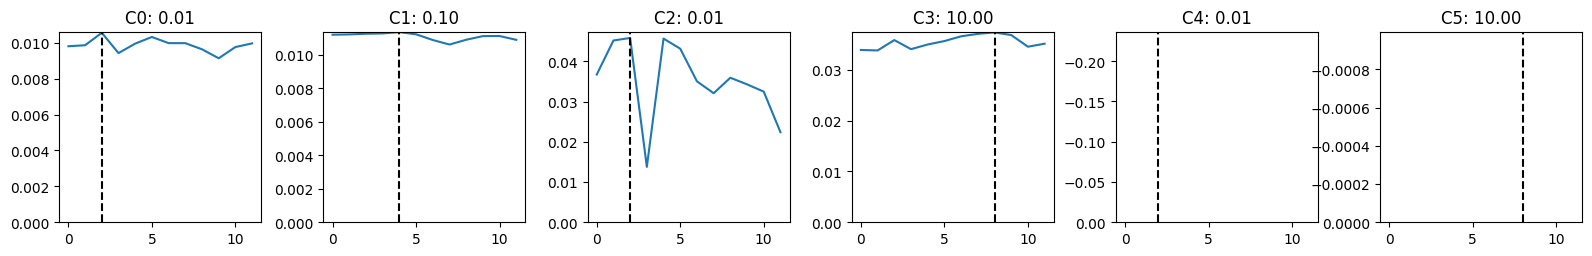

In [16]:
XTregs0 = np.zeros(data.NC)

num_col = np.minimum(data.NC, 6)
ss(1, num_col)
for cc in range(data.NC):
    b = np.argmax(LLsR[:, cc])
    XTregs0[cc] = reglist[b]
    
    if cc < num_col:
        plt.subplot(1, num_col, cc+1)
        plt.plot(LLsR[:, cc])
        ys = plt.ylim() 
        plt.plot([b, b], [0, ys[1]], 'k--')
        plt.ylim([0, ys[1]])
        plt.title("C%d: %0.2f"%(cc, XTregs0[cc]))
plt.show()